In [ ]:
pip install yfinance numpy pandas scikit-learn keras tensorflow


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Fetch stock data
ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2023-01-01")
data = data[['Close']]  # Use only the 'Close' price

# Display first few rows of data
print(data.head())


[*********************100%%**********************]  1 of 1 completed

                Close
Date                 
2015-01-02  27.332500
2015-01-05  26.562500
2015-01-06  26.565001
2015-01-07  26.937500
2015-01-08  27.972500


In [6]:
# Convert data to numpy array
dataset = data.values

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Create the datasets for training the LSTM model
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [7]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


C:\Users\prajw\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 0.0175 - val_loss: 0.0018
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 8.6006e-04 - val_loss: 0.0023
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 8.8823e-04 - val_loss: 0.0030
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 8.0520e-04 - val_loss: 0.0016
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 7.5357e-04 - val_loss: 0.0019
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 9.7626e-04 - val_loss: 0.0014
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 8.7630e-04 - val_loss: 0.0016
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 7.5280e-04 - val_loss: 0.0025
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Train RMSE: 2.4872278130690093
Test RMSE: 6.445244474882162


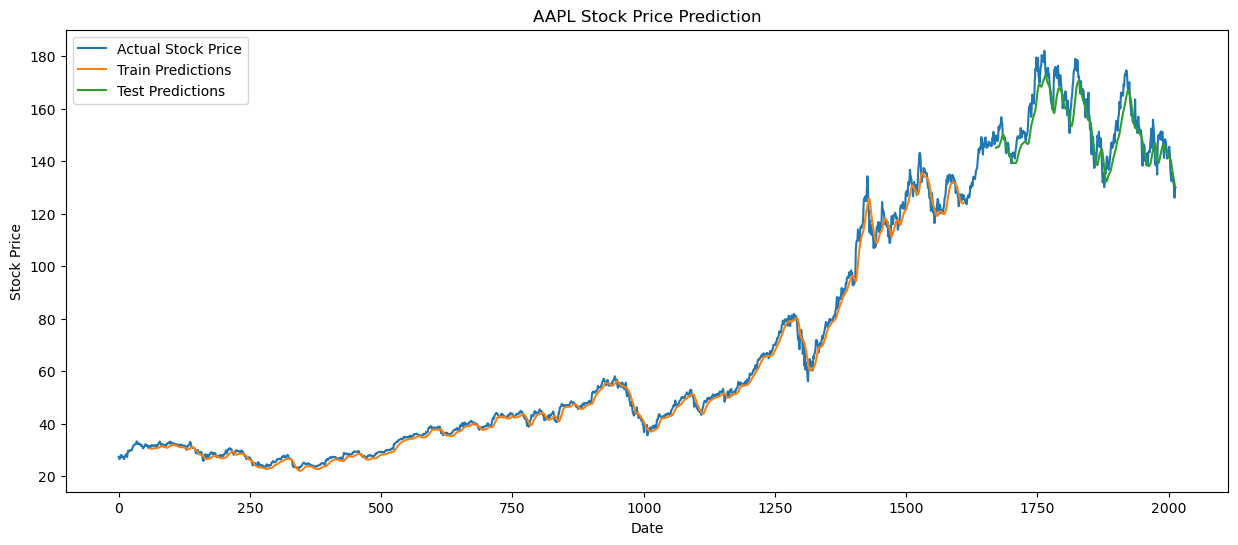

In [8]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
from sklearn.metrics import mean_squared_error
import math

train_rmse = math.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_rmse = math.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Plot the results
import matplotlib.pyplot as plt

# Shift train predictions for plotting
train_plot = np.empty_like(dataset)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

# Shift test predictions for plotting
test_plot = np.empty_like(dataset)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(dataset) - 1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Stock Price')
plt.plot(train_plot, label='Train Predictions')
plt.plot(test_plot, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.legend()
plt.show()
